In [1]:
import nltk
import pandas as pd
import sqlite3
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [2]:
# Ensure you have the necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/woojay/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/woojay/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
def query_database():
    # Connect to the SQLite database
    conn = sqlite3.connect('../data/arxiv_papers.db')
    cursor = conn.cursor()
    
    # Query all entries in the 'papers' table
    cursor.execute("SELECT paper_id, title, summary, updated FROM papers")
    rows = cursor.fetchall()
    
    # Construct the list of dictionaries
    articles = [
        {'id': row[0], 'title': row[1], 'summary': row[2], 'date': row[3]} for row in rows
    ]
    
    # Close the database connection
    conn.close()
    
    return articles


In [4]:
articles = query_database()
# Convert articles to a DataFrame
df = pd.DataFrame(articles)

# Preprocess summaries: tokenize, lower, remove stopwords
stop_words = set(stopwords.words('english'))
df['processed_summary'] = df['summary'].apply(lambda x: [word.lower() for word in word_tokenize(x) if word.isalpha() and word.lower() not in stop_words])

In [5]:
# Frequency analysis
all_words = [word for summary in df['processed_summary'] for word in summary]
word_freq = Counter(all_words)


In [6]:
# Convert to DataFrame for easier manipulation
freq_df = pd.DataFrame(word_freq.items(), columns=['word', 'frequency']).sort_values(by='frequency', ascending=False)

In [7]:
# Trend analysis: Count word occurrences by year
df['year'] = pd.to_datetime(df['date']).dt.year
trends = df.explode('processed_summary').groupby(['year', 'processed_summary']).size().reset_index(name='counts')

In [8]:
# Saving results to SQLite database
conn = sqlite3.connect('../data/arxiv_analysis.db')
cursor = conn.cursor()

# Create tables
cursor.execute('''
CREATE TABLE IF NOT EXISTS word_frequency (
    word TEXT PRIMARY KEY,
    frequency INTEGER
)
''')

cursor.execute('''
CREATE TABLE IF NOT EXISTS word_trends (
    year INTEGER,
    word TEXT,
    count INTEGER,
    PRIMARY KEY (year, word)
)
''')

# Insert frequency analysis results
for _, row in freq_df.iterrows():
    cursor.execute('REPLACE INTO word_frequency (word, frequency) VALUES (?, ?)', (row['word'], row['frequency']))

# Insert trend analysis results
for _, row in trends.iterrows():
    cursor.execute('REPLACE INTO word_trends (year, word, count) VALUES (?, ?, ?)', (row['year'], row['processed_summary'], row['counts']))

conn.commit()
conn.close()


In [9]:
print("Frequency and trend analysis data saved to database.")


Frequency and trend analysis data saved to database.


In [10]:
# Connect to the SQLite database
conn = sqlite3.connect('../data/arxiv_analysis.db')

TOP_K=200
# Load the data from the database
word_freq_desc = pd.read_sql_query(f"SELECT * FROM word_frequency ORDER BY frequency DESC LIMIT {TOP_K}", conn)
word_freq_asc = pd.read_sql_query(f"SELECT * FROM word_frequency ORDER BY frequency ASC LIMIT {TOP_K}", conn)
word_trends = pd.read_sql_query("SELECT * FROM word_trends WHERE word IN (SELECT word FROM word_frequency ORDER BY frequency DESC LIMIT 10)", conn)

conn.close()

In [11]:
conn = sqlite3.connect('../data/arxiv_analysis.db')

print(pd.read_sql_query("SELECT * FROM word_frequency WHERE word = 'delve'", conn))
conn.close()

    word  frequency
0  delve         36


/tmp/ipykernel_9111/4226150007.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='frequency', y='word', data=word_freq_desc, palette='viridis')


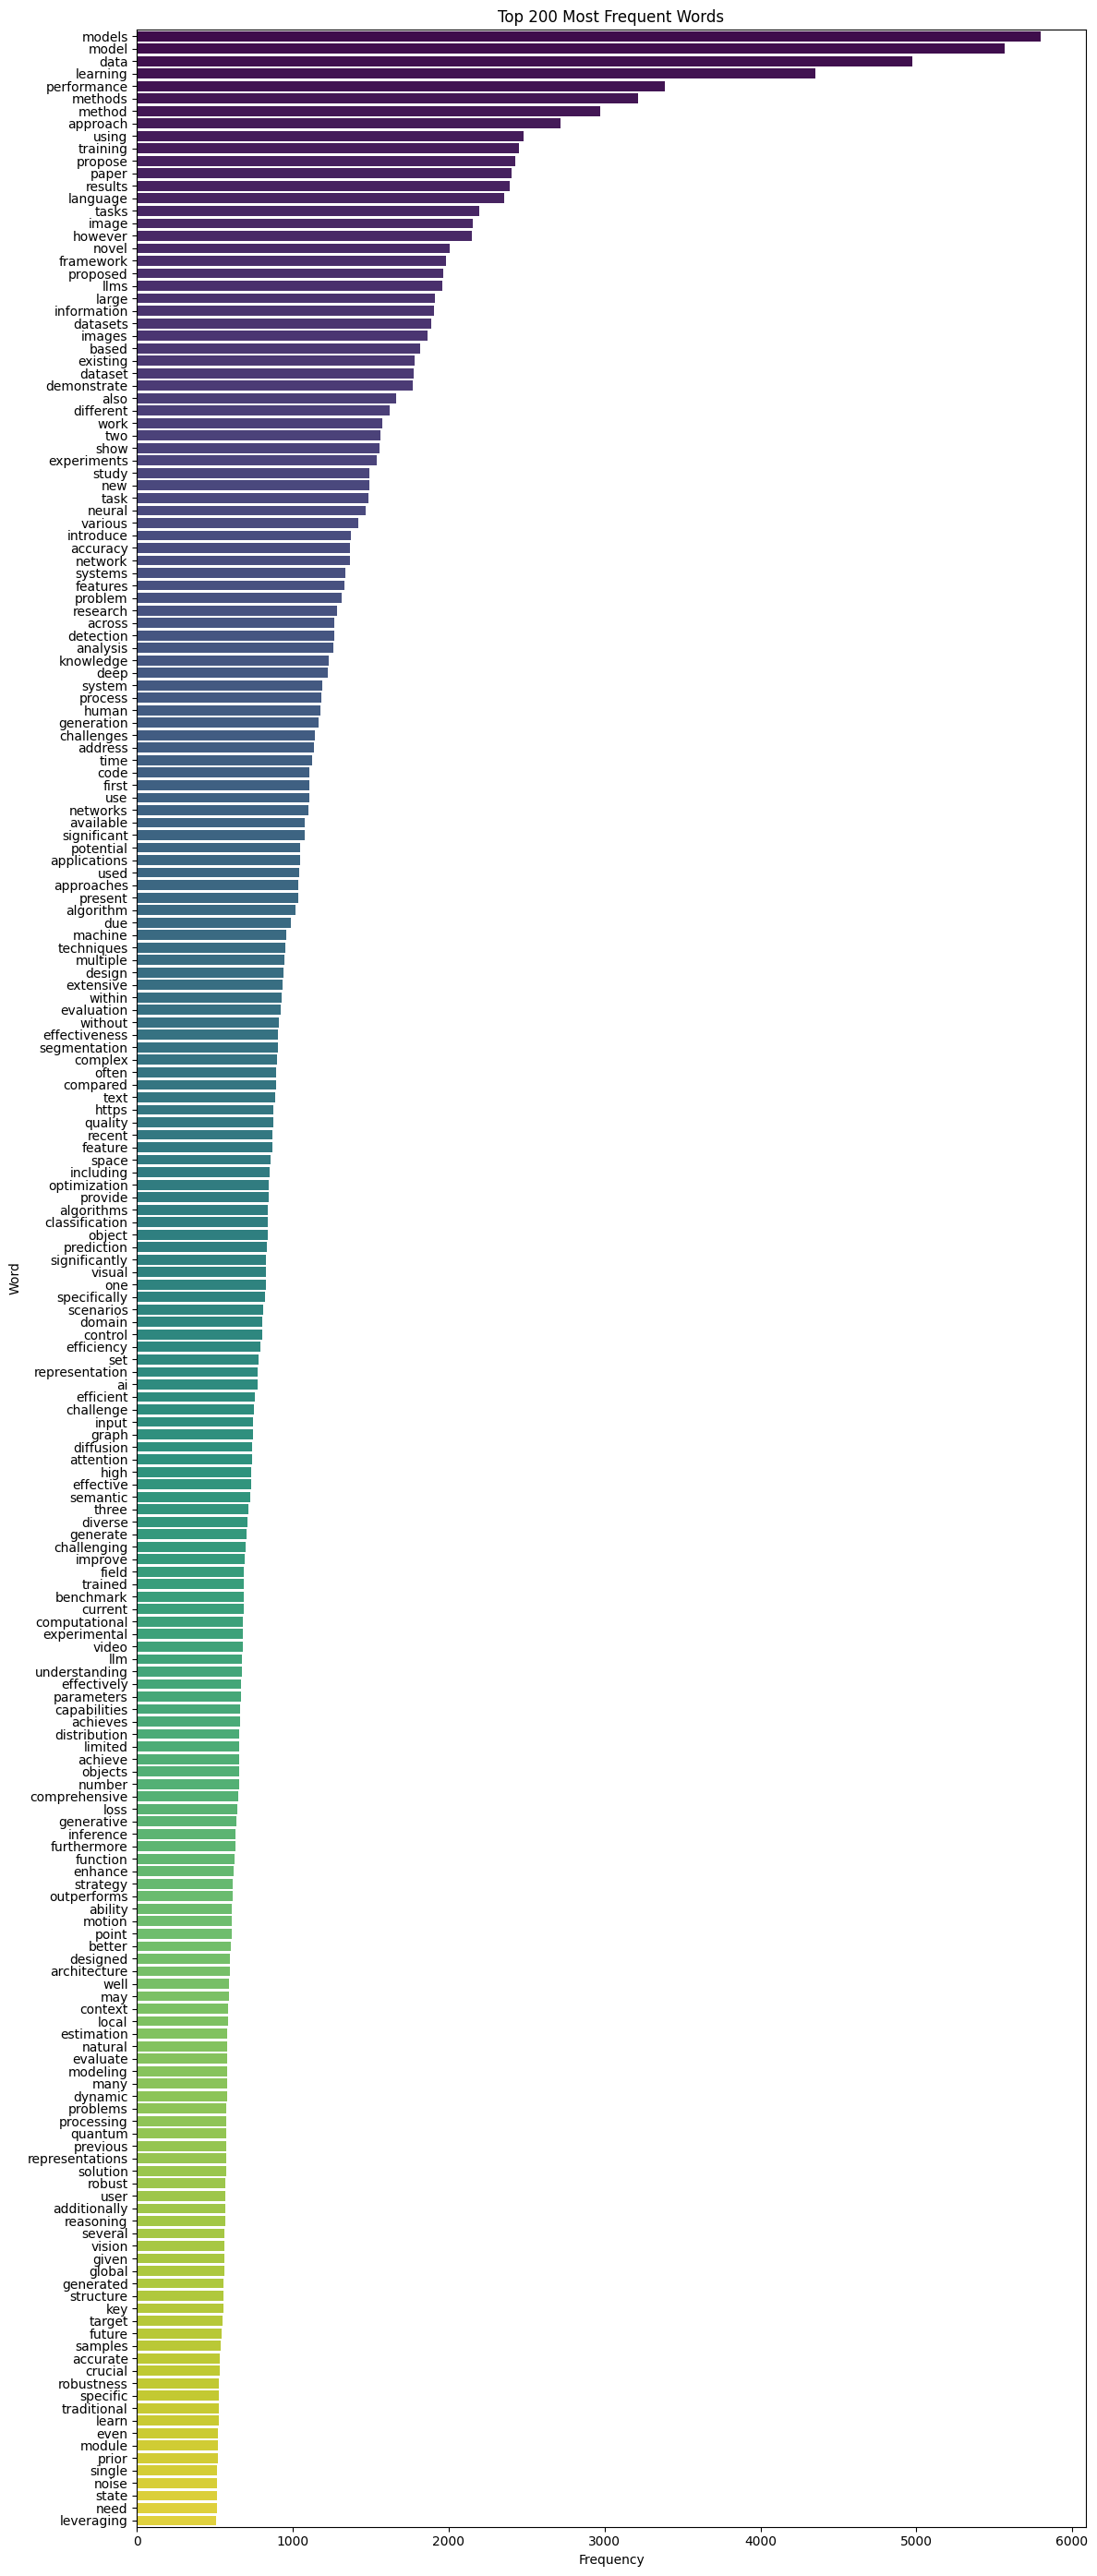

/tmp/ipykernel_9111/4226150007.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='frequency', y='word', data=word_freq_asc, palette='viridis')


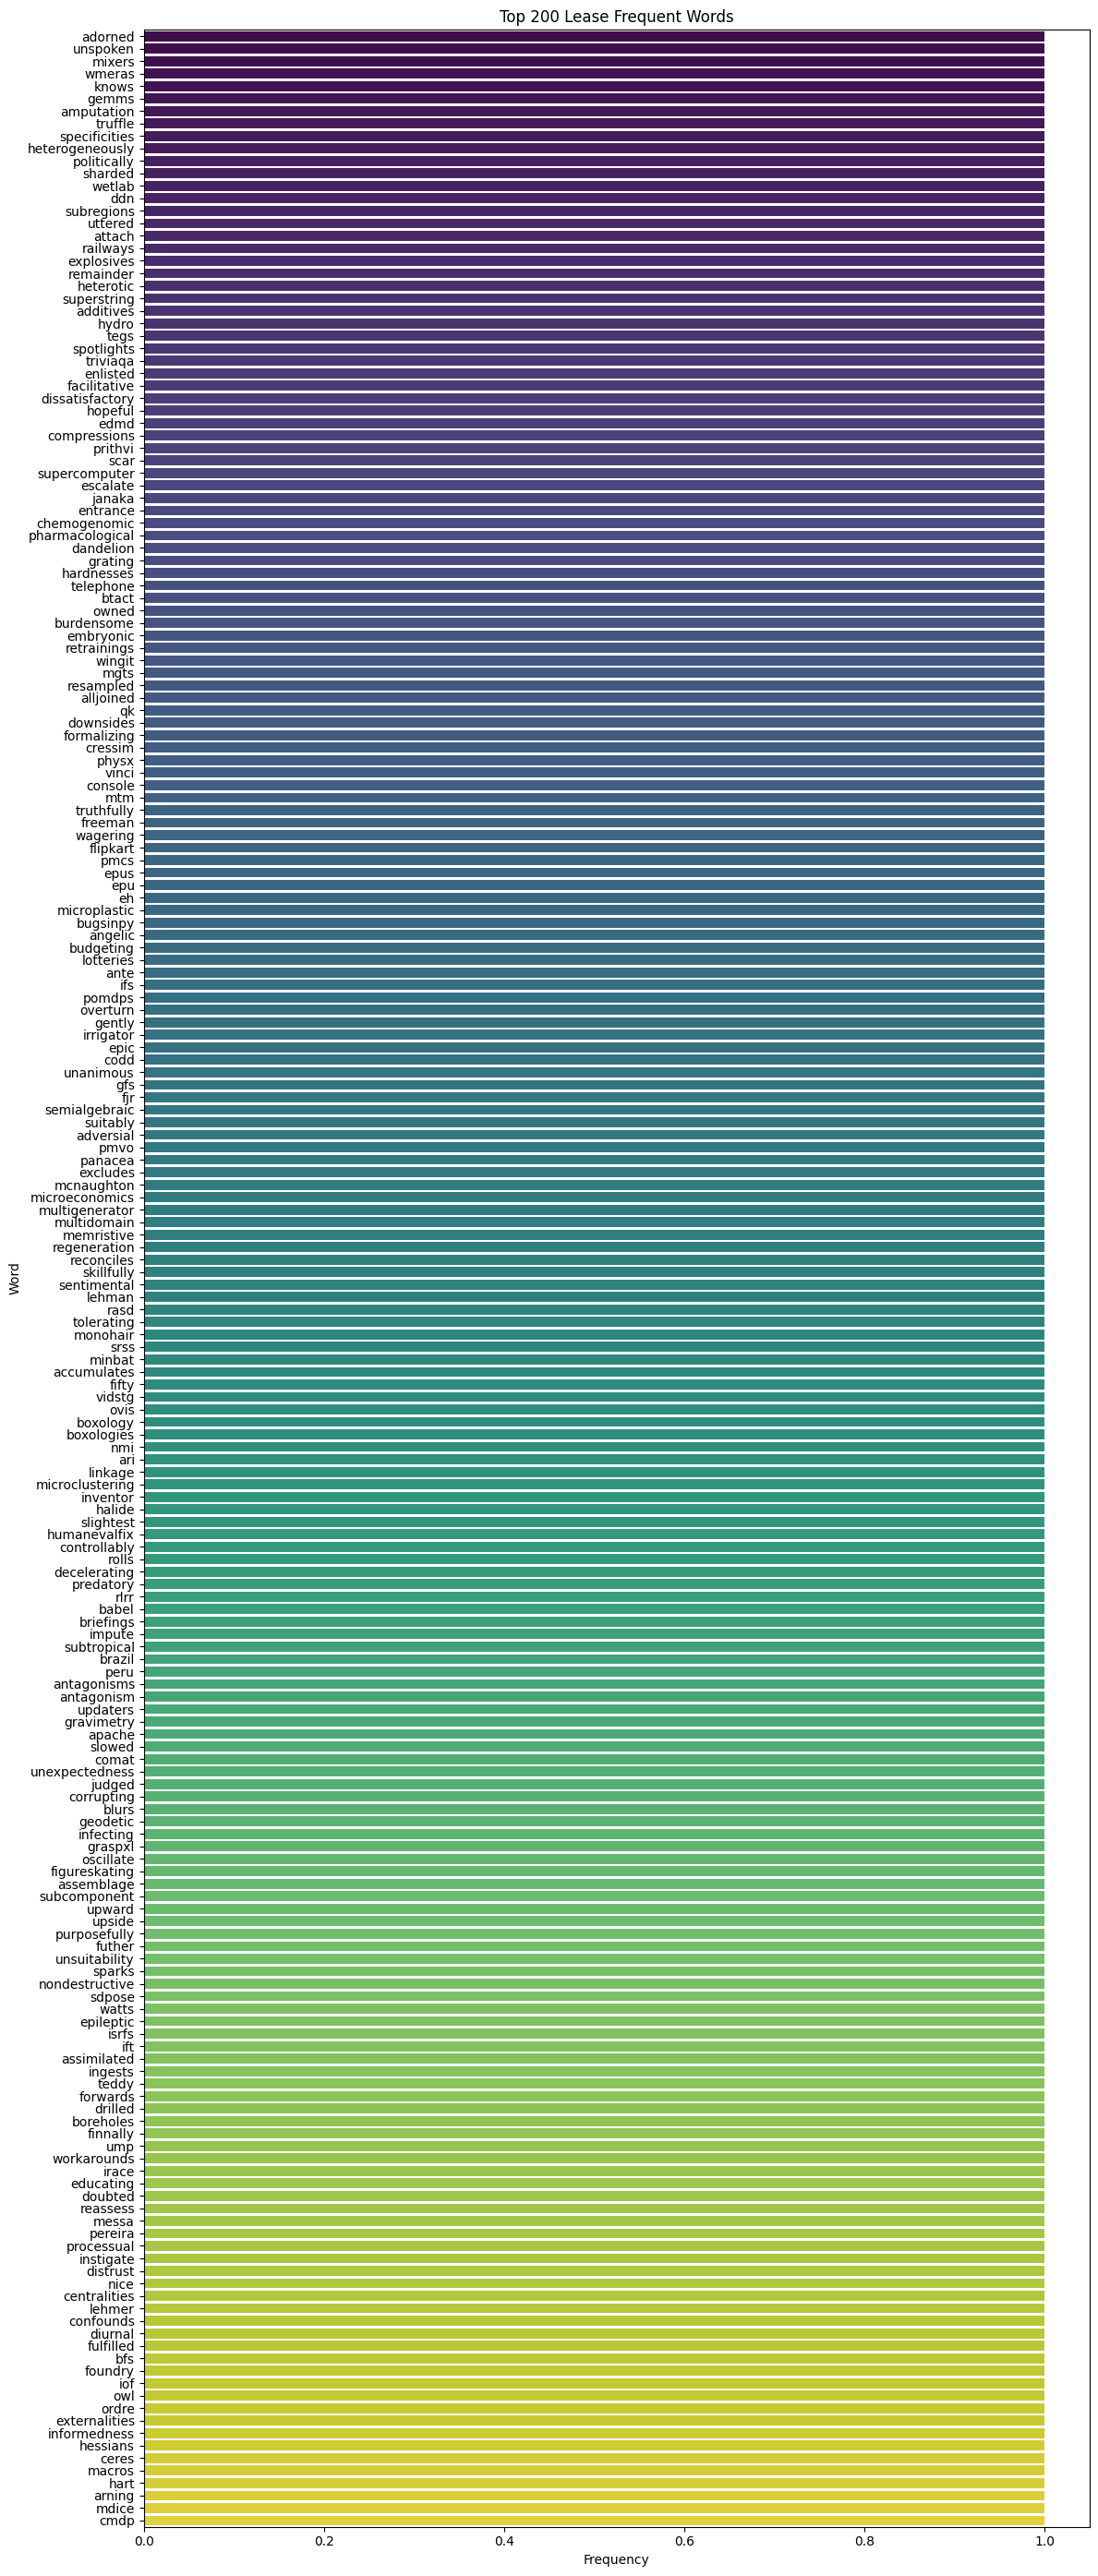

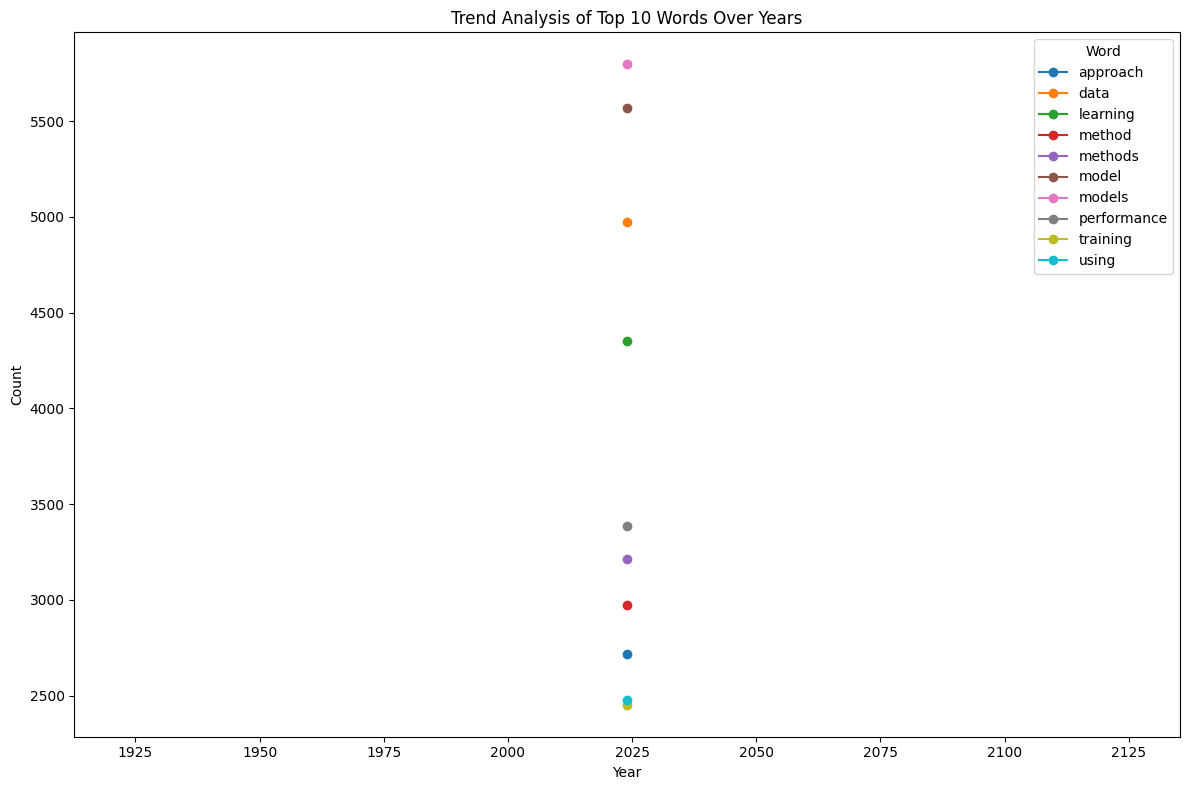

In [12]:
# Visualization

# Top TOP_K most frequent words visualization
plt.figure(figsize=(12, 28))
sns.barplot(x='frequency', y='word', data=word_freq_desc, palette='viridis')
plt.title(f'Top {TOP_K} Most Frequent Words')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.tight_layout()
plt.show()

# Top TOP_K lease frequent words visualization
plt.figure(figsize=(12, 28))
sns.barplot(x='frequency', y='word', data=word_freq_asc, palette='viridis')
plt.title(f'Top {TOP_K} Lease Frequent Words')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.tight_layout()
plt.show()

# Trends of top 10 most frequent words over years
plt.figure(figsize=(12, 8))
for word in word_trends['word'].unique():
    subset = word_trends[word_trends['word'] == word]
    plt.plot(subset['year'], subset['count'], marker='o', label=word)

plt.title('Trend Analysis of Top 10 Words Over Years')
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend(title='Word')
plt.tight_layout()
plt.show()

In [13]:
conn = sqlite3.connect('../data/arxiv_papers.db')

tool = pd.read_sql_query(f"SELECT * FROM papers WHERE summary LIKE '%tool%'", conn)
tool

,paper_id,title,summary,updated,concise_summary,interested
0,http://arxiv.org/abs/2403.19925v1,Decision Mamba: Reinforcement Learning via Seq...,"Decision Transformer, a promising approach t...",2024-03-29T02:25:55Z,The study explores enhancing the Decision Tran...,0
1,http://arxiv.org/abs/2403.19444v1,Transparent and Clinically Interpretable AI fo...,The rapidly advancing field of Explainable A...,2024-03-28T14:15:13Z,Explainable Artificial Intelligence (XAI) addr...,0
2,http://arxiv.org/abs/2403.18969v1,A Survey on Large Language Models from Concept...,Recent advancements in Large Language Models...,2024-03-27T19:35:41Z,Recent advancements in Large Language Models (...,0
3,http://arxiv.org/abs/2403.18637v1,Transformers-based architectures for stroke se...,Stroke remains a significant global health c...,2024-03-27T14:42:08Z,This review explores how deep learning techniq...,0
4,http://arxiv.org/abs/2403.18985v1,Robustness and Visual Explanation for Black Bo...,We present a generic Reinforcement Learning ...,2024-03-27T20:07:39Z,A Reinforcement Learning framework is proposed...,0
...,...,...,...,...,...,...
408,http://arxiv.org/abs/2404.12337v1,Adiabatic Transformations in Dissipative and N...,The quantum geometric tensor has established...,2024-04-18T17:05:08Z,A new universal approach for studying phase tr...,0
409,http://arxiv.org/abs/2404.11799v1,Persistent interaction topology in data analysis,"Topological data analysis, as a tool for ext...",2024-04-17T23:38:24Z,Topological data analysis has evolved with new...,0
410,http://arxiv.org/abs/2404.11725v1,Postoperative glioblastoma segmentation: Devel...,Accurately assessing tumor removal is paramo...,2024-04-17T20:23:07Z,A pipeline combining MRI scans and neural netw...,0
411,http://arxiv.org/abs/2404.11768v1,Tensor-Networks-based Learning of Probabilisti...,Algorithms developed to solve many-body quan...,2024-04-17T21:51:03Z,Developing matrix product operator algorithms ...,0


In [14]:
import requests
import json

In [15]:
url = "http://localhost:8000/query"
data = {
    "top_k": 10,
    "query_text": "infrastructure as code"
}

# Make the POST request
response = requests.post(url, json=data)

articles = json.loads(response.text)

for article in articles:
    print('-'*10)
    print(article["id"])
    print(article["summary"])

----------
http://arxiv.org/abs/2404.00227v1
Infrastructure as Code (IaC) automates the management and provisioning of IT infrastructure using machine-readable code to ensure consistency, reproducibility, and scalability, despite requiring specialized skills and manual effort for orchestration. Large Language Models (LLMs) are being explored as a potential solution to automate IaC configurations due to their language processing abilities and success in code understanding and generation tasks, aiming to address the challenges and future research opportunities in this area.
----------
http://arxiv.org/abs/2404.06484v1
Governments are providing funding for open source software development to address various concerns, but how developers perceive the benefits and drawbacks of this funding remains uncertain. A case study on scikit-learn reveals insights into the success of a public-private funding model and the governance mechanisms used to maintain community ethos, offering practical implic

In [19]:
url = "http://localhost:8000/choose"
data = {
    "i": 5,
    "k": 40,
    "query_text": "infrastructure as code"
}

# Make the POST request
response = requests.post(url, json=data)
response.text
# articles = json.loads(response.text)
# articles

'[{"id":"http://arxiv.org/abs/2404.00227v1","summary":"Infrastructure as Code (IaC) automates the management and provisioning of IT infrastructure using Large Language Models (LLMs) to automate IaC configurations, addressing challenges and future research opportunities in this area.","reason":"Novel application of LLMs in automating infrastructure management."},{"id":"http://arxiv.org/abs/2404.06484v1","summary":"A case study on scikit-learn reveals insights into the success of a public-private funding model for open source software development, offering practical implications for OSS communities, companies, and governments.","reason":"Unique examination of funding models for sustaining open source projects."},{"id":"http://arxiv.org/abs/2404.05085v1","summary":"CodeFlow introduces a unified programming model for heterogeneous computing systems, simplifying programming efforts and improving performance on accelerators without manual code modifications.","reason":"Cutting-edge approach 

In [20]:
j = json.loads(response.text)
print(j)

[{'id': 'http://arxiv.org/abs/2404.00227v1', 'summary': 'Infrastructure as Code (IaC) automates the management and provisioning of IT infrastructure using Large Language Models (LLMs) to automate IaC configurations, addressing challenges and future research opportunities in this area.', 'reason': 'Novel application of LLMs in automating infrastructure management.'}, {'id': 'http://arxiv.org/abs/2404.06484v1', 'summary': 'A case study on scikit-learn reveals insights into the success of a public-private funding model for open source software development, offering practical implications for OSS communities, companies, and governments.', 'reason': 'Unique examination of funding models for sustaining open source projects.'}, {'id': 'http://arxiv.org/abs/2404.05085v1', 'summary': 'CodeFlow introduces a unified programming model for heterogeneous computing systems, simplifying programming efforts and improving performance on accelerators without manual code modifications.', 'reason': 'Cuttin

In [21]:
print(json.dumps(j, indent=4))

[
    {
        "id": "http://arxiv.org/abs/2404.00227v1",
        "summary": "Infrastructure as Code (IaC) automates the management and provisioning of IT infrastructure using Large Language Models (LLMs) to automate IaC configurations, addressing challenges and future research opportunities in this area.",
        "reason": "Novel application of LLMs in automating infrastructure management."
    },
    {
        "id": "http://arxiv.org/abs/2404.06484v1",
        "summary": "A case study on scikit-learn reveals insights into the success of a public-private funding model for open source software development, offering practical implications for OSS communities, companies, and governments.",
        "reason": "Unique examination of funding models for sustaining open source projects."
    },
    {
        "id": "http://arxiv.org/abs/2404.05085v1",
        "summary": "CodeFlow introduces a unified programming model for heterogeneous computing systems, simplifying programming efforts and im